# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, May 20, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

In [1]:
# automatically reload dependencies and repository content so that kernel need not be restarted
%load_ext autoreload
%autoreload 2

## Get the data

In [ ]:
import sys
import os
from os.path import join
from os.path import abspath
from os.path import split

import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

root_dir = os.getcwd()
if root_dir not in sys.path:
    sys.path.append(root_dir)
    
train_path = 'train'

data_folder_name = 'image-training-corpus+annotations'
DATA_FOLDER_DIR = os.path.abspath(os.path.join(root_dir, data_folder_name))

data_zip_name = 'dl2018-image-proj.zip'
DATA_ZIP_DIR = os.path.abspath(os.path.join(DATA_FOLDER_DIR, data_zip_name))

with zipfile.ZipFile(DATA_ZIP_DIR) as zip_f:
    zip_f.extractall(train_path)

The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

In [2]:
import torch


device = None
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda:0")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using GPU


In [3]:
from image_dataset import ImageDataset
from data_augmentation import DataAugmentation

dataAugmentation = DataAugmentation()
dataset = ImageDataset(dataAugmentation = dataAugmentation)

In [4]:
trainDataset = ImageDataset(range(1, 20001), dataAugmentation=dataAugmentation)
valDataset = ImageDataset(range(19001,20001))

## Define the model architecture and train model

In [11]:
from torchvision import models
from ensemble_model import EnsembleModel, IdentityLayer

torch.cuda.empty_cache()

resNext = models.resnext101_32x8d(pretrained=True)

for param in resNext.parameters():
    param.requires_grad = False

resNextInFeatures = resNext.fc.in_features

resNext.fc = IdentityLayer()

dense = models.densenet201(pretrained=True)

for param in dense.parameters():
    param.requires_grad = False
    
denseInFeatures = dense.classifier.in_features

dense.classifier = IdentityLayer()


model = EnsembleModel(device, [resNext, dense], [resNextInFeatures, denseInFeatures], 14)

In [6]:
from train_model import train_model


model, logs = train_model(
    model,
    trainDataset,
    valDataset,
    device,
    numberOfEpochs = 14,
    returnLogs = True
)

Epoch 0/14
----------
Validating...

Progress: 100%

Loss: 0.1165 Accuracy: 0.9627
Precision: 0.7401 Recall: 0.7342
F1: 0.7372 Duration: 1m 15s

Epoch 1/14
----------
Training...

Progress: 100%

Loss: 0.1442 Accuracy: 0.9537
Precision: 0.7252 Recall: 0.5775
F1: 0.6430 Duration: 37m 0s

Validating...

Progress: 100%

Loss: 0.1301 Accuracy: 0.9584
Precision: 0.7070 Recall: 0.7091
F1: 0.7081 Duration: 1m 57s

Epoch 2/14
----------
Training...

Progress: 100%

Loss: 0.1426 Accuracy: 0.9545
Precision: 0.7325 Recall: 0.5835
F1: 0.6495 Duration: 35m 50s

Validating...

Progress: 100%

Loss: 0.1378 Accuracy: 0.9580
Precision: 0.7503 Recall: 0.6148
F1: 0.6759 Duration: 1m 21s

Epoch 3/14
----------
Training...

Progress: 100%

Loss: 0.1444 Accuracy: 0.9545
Precision: 0.7320 Recall: 0.5848
F1: 0.6502 Duration: 35m 12s

Validating...

Progress: 100%

Loss: 0.1022 Accuracy: 0.9679
Precision: 0.7790 Recall: 0.7673
F1: 0.7731 Duration: 1m 20s

Epoch 4/14
----------
Training...

Progress: 100%

Loss

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [7]:
torch.save(model, 'ensemble_model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".  [See more here on how to load the model back](https://github.com/pytorch/pytorch/blob/761d6799beb3afa03657a71776412a2171ee7533/docs/source/notes/serialization.rst) if you want to continue training later.

## Test your model

Load model back from state_dict and perform test on validation set (using appropriate metrics) 

In [8]:
model = torch.load("ensemble_model.pkl")

Validation images:



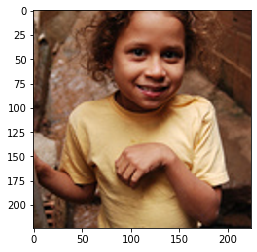

True labels:  ['portrait', 'people', 'female']
Predicted labels: ['male', 'portrait', 'people', 'female']



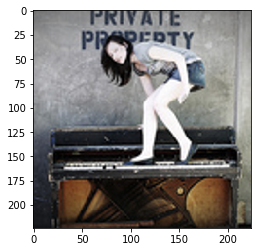

True labels:  ['portrait', 'people', 'female']
Predicted labels: ['people']



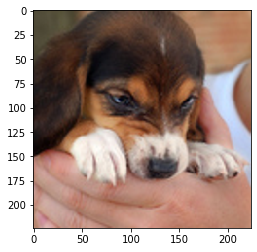

True labels:  ['dog']
Predicted labels: []



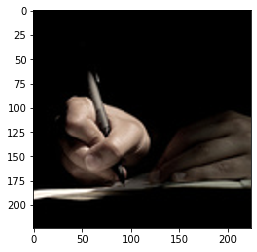

True labels:  []
Predicted labels: ['male', 'people']



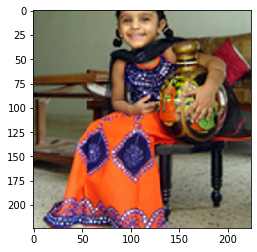

True labels:  ['portrait', 'people', 'female']
Predicted labels: ['portrait', 'people', 'female']



In [11]:
from example_prediction_shower import showExamplePredictions

print("Validation images:")
print()
showExamplePredictions(model, valDataset, device, 5)

Training images:



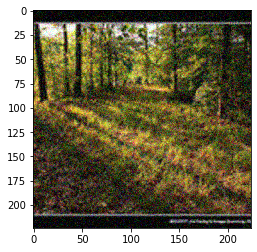

True labels:  []
Predicted labels: []



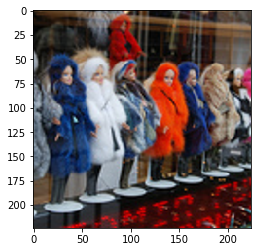

True labels:  []
Predicted labels: ['people', 'female']



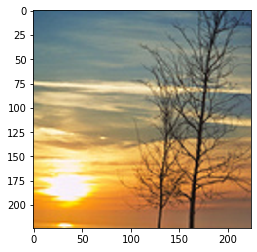

True labels:  ['tree']
Predicted labels: ['clouds', 'tree']



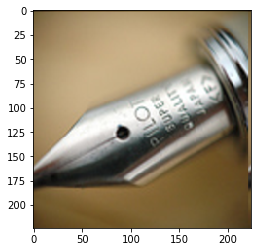

True labels:  []
Predicted labels: ['bird']



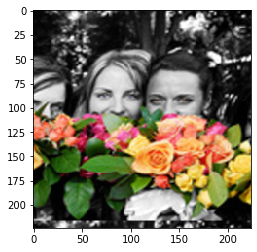

True labels:  ['portrait', 'people', 'female', 'flower']
Predicted labels: ['people', 'female', 'flower']



In [12]:
print("Training images:")
print()
showExamplePredictions(model, trainDataset, device, 5)

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

In [21]:
import pandas as pd

testDataset = ImageDataset(range(20001,25001), trainImagesDir="test/images", hasTrainLabels=False)
results = pd.DataFrame(index=range(20001,25001), columns=["clouds","male","bird","dog","river","portrait","baby","night","people","female","sea","tree","car","flower"])
results = results.fillna(0)
model.eval()
decisionThresholds = torch.tensor([0.5]*14)
for i, data in enumerate(testDataset):
    print("Progress: {} / {}".format(i+1, len(testDataset)), end="\r")
    id = i+20001
    predictions = model(data["imageTensor"].to(device).unsqueeze(0)).cpu()
    labels = (predictions >= decisionThresholds).numpy()[0]
    results.loc[id] = labels
results = results[["baby", "bird", "car", "clouds", "dog", "female", "flower", "male", "night", "people", "portrait", "river", "sea", "tree"]]
results = results.astype(int)
results

,baby,bird,car,clouds,dog,female,flower,male,night,people,portrait,river,sea,tree
20001,False,False,False,False,False,False,False,False,False,False,False,False,False,False
20002,False,False,False,False,False,False,False,True,False,True,False,False,False,False
20003,False,False,False,False,False,False,False,False,False,False,False,False,False,False
20004,False,False,False,False,False,False,False,False,False,False,False,False,False,False
20005,False,False,False,False,False,True,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24996,False,False,False,False,False,False,False,False,False,False,False,False,False,False
24997,False,False,False,False,False,False,False,False,False,False,False,False,False,False
24998,False,False,False,True,False,False,False,False,False,False,False,False,False,False
24999,False,False,False,False,False,False,True,False,False,False,False,False,False,True


In [23]:
results.to_csv("results.txt", sep=" ", header=False, index=False)

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.